In [2]:
import gpmultipy, scipy
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from gpmultipy import dataset
from gpmultipy.model import Model
from gpmultipy.prior import Prior
from gpmultipy.kernel import RBF, White, Addition
from gpmultipy.freeze import Freezer
from gpmultipy.sampler.slice import Slice
from gpmultipy.kernel import Product, Linear

In [4]:
%matplotlib inline

In [5]:
def printSample(sample,depth=1):
    keys = sample.keys()
    keys.sort()
    
    for k in keys:
        if type(sample[k]) == dict:
            print "\t".join([""]*depth) + k
            printSample(sample[k],depth=depth+1)
        else:
            print "\t".join([""]*depth) + "%s: %s"%(k,str(sample[k]))

In [6]:
ds = dataset.DataSet('data/')
x,y,effect,labels = ds.build(Strain='ura3',mM_PQ=0.0,scale='range',effects=['Well'])
y = np.log2(y)
y = (y-y.mean())/y.std()

In [7]:
edge = range(101,111) + range(111,191,10) + range(120,191,10) + range(191,201) + range(201,211) + range(211,291,10) + range(220,291,10) + range(291,301)
edge = np.array(edge)
edge

array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 121, 131,
       141, 151, 161, 171, 181, 120, 130, 140, 150, 160, 170, 180, 190,
       191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203,
       204, 205, 206, 207, 208, 209, 210, 211, 221, 231, 241, 251, 261,
       271, 281, 220, 230, 240, 250, 260, 270, 280, 290, 291, 292, 293,
       294, 295, 296, 297, 298, 299, 300])

In [8]:
dist = np.array([min(abs(l-edge)) for l in labels[0]])
position = (dist==0).astype(int)

In [9]:
yKernel = White(1,.1)
k1 = RBF(1,1,1)

p = y.shape[1]
dm = np.ones((1,p))

prior = Prior(x,k1,range(dm.shape[0]))

model = Model(x,y,dm)

In [10]:
ySigmaSlice = Slice('ySigma',
                    lambda x: model.dataLikelihood(yKernel,sigma=x),
                    lambda x: scipy.stats.lognorm(1,scale=1e-0).logpdf(x),
                    .2,5,logspace=True)

kSigmaSlice = Slice('kSigma',
                    lambda x: prior.loglikelihood(model.beta,sigma=x),
                    lambda x: scipy.stats.uniform(1e-2,1e2).logpdf(x),
                    .2,5,logspace=True)

kLengthscaleSlice = Slice('kLengthscale',
                    lambda x: prior.loglikelihood(model.beta,lengthscale=x),
                    lambda x: scipy.stats.uniform(1e-2,1e2).logpdf(x),
                    .2,5,logspace=True)

samples = []
freeze = Freezer(yKernel=yKernel,k1=k1,model=model)

In [11]:
thin = 10
burnin = 0
nsample = 3000

for i in range(nsample):
    prior.sample(model,yKernel)
    
    yKernel.sigma = ySigmaSlice.sample(yKernel.sigma)
    
    k1.sigma = kSigmaSlice.sample(k1.sigma)
    k1.lengthscale = kLengthscaleSlice.sample(k1.lengthscale)

    if i % thin == 0 and i > burnin:
        f = freeze.freeze()
        del f['model']
        
        print "~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~"
        print model.dataLikelihood(yKernel)
        printSample(f)
        print
        
        samples.append(freeze.freeze())

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
-861.835245736
k1
	lengthscale: 0.145484630213
	sigma: 0.0365777619197
yKernel
	sigma: 0.0643949965788

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
-870.535533985
k1
	lengthscale: 0.155313115295
	sigma: 0.0580006471825
yKernel
	sigma: 0.0633750340456

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
-873.322599681
k1
	lengthscale: 0.176995630754
	sigma: 0.048794880273
yKernel
	sigma: 0.0650087823024

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
-870.383158328
k1
	lengthscale: 0.158495982431
	sigma: 0.0357079296686
yKernel
	sigma: 0.0646442048476

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
-877.212982301
k1
	lengthscale: 0.172177581909
	sigma: 0.0570831798034
yKernel
	sigma: 0.0650716448974

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
-870.198348154
k1
	lengthscale: 0.158281667511
	sigma: 0.0560351385164
yKernel
	sigma: 0.0664743000177

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
-879.037243977
k1
	lengthscale: 0.17769714026
	sigma: 0.0331647059972
yKernel
	sigma: 0.066298119

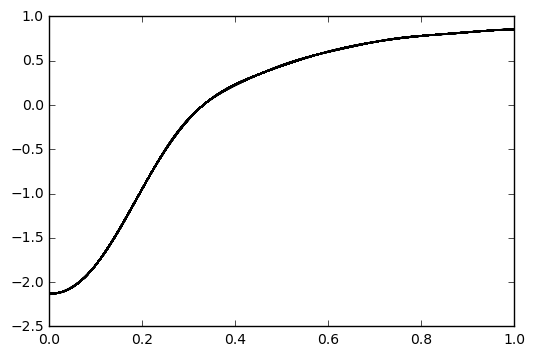

In [14]:
plt.plot(x,np.array([s['model']['beta'][:,0] for s in samples]).T,c='k',alpha=.5);

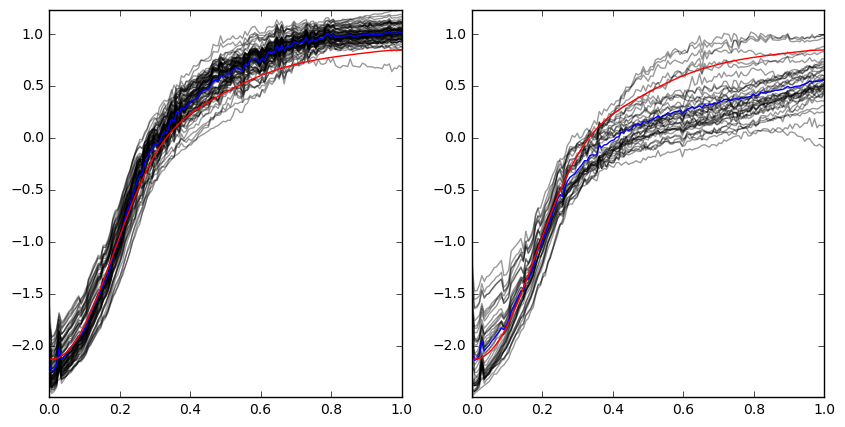

In [13]:
beta = samples[-1]['model']['beta']

plt.figure(figsize=(10,5))
for i,p in enumerate([0,1]):
    select = position==p
    
    plt.subplot(1,2,i+1)
    plt.plot(x,y[:,select],c='k',alpha=.4)
    plt.plot(x,y[:,select].mean(1),c='b',alpha=1)
    plt.plot(x,beta[:,0],c='r')
    
    plt.ylim(y.min(),y.max())

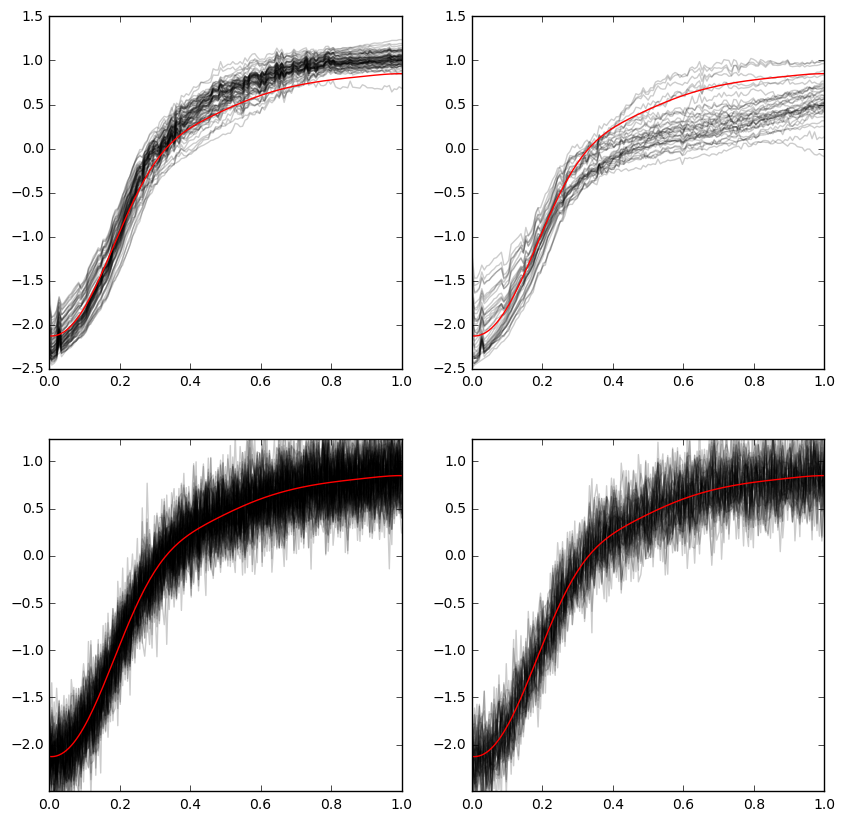

In [15]:
beta = samples[-1]['model']['beta']

plt.figure(figsize=(10,10))
for i,p in enumerate([0,1]):
    select = position==p
    
    plt.subplot(2,2,i+1)
    plt.plot(x,y[:,select],c='k',alpha=.2)
    plt.plot(x,beta[:,0],c='r')
    
    plt.subplot(2,2,i+3)
    sample = scipy.stats.multivariate_normal.rvs(beta[:,0],yKernel.K(x),size=sum(select)).T
    plt.plot(x,sample,c='k',alpha=.2)
    plt.plot(x,beta[:,0],c='r')
    plt.ylim(y.min(),y.max())